In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler,StandardScaler

fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='generator_modelVAE9-10k.pth'
filename = "modelvae9-"
ldim=100
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2 * latent_dim)  # 2 for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, input_dim),
            #nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        #recon = torch.sigmoid(recon) 
        return recon, mu, logvar

        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). 
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)



# Normalizacion
scaler = StandardScaler()


expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir de vuelta a DataFrames
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Convertirlos a tensores y pasarlos a la GPU
expression_data = torch.FloatTensor(expression_data.values).to(device)
methylation_data = torch.FloatTensor(methylation_data.values).to(device)
assign_data = torch.FloatTensor(assign_data.values).to(device)

combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

True


In [59]:





# Modelos y optimizadores
vae = VAE(combined_data.shape[1],ldim).to(device)
print(f'El modelo VAE tiene {count_parameters(vae)} parámetros entrenables.')
vae_optimizer = optim.RMSprop(vae.parameters(), lr=0.0002)

# Función de pérdida para VAE
def loss_vae(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)  # pérdida de reconstrucción
    #recon_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # divergencia KL
    total_loss = recon_loss + kl_divergence
    return total_loss, recon_loss, kl_divergence

# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    epoch_recon_loss = 0.0
    epoch_kl_divergence = 0.0
    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)

        vae_optimizer.zero_grad()
        
        recon_data, mu, logvar = vae(real_data)
        if ((epoch+1) % 100 == 0) and (idx ==0):
                print(recon_data)
        loss, recon_loss, kl_div = loss_vae(recon_data, real_data, mu, logvar)
        epoch_recon_loss += recon_loss.item()
        epoch_kl_divergence += kl_div.item()
        loss.backward()
              # Verificar si la pérdida es NaN
        if torch.isnan(loss):
            print("NaN detected!")
            break
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        vae_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Total Loss: {loss.item()} | Recon Loss: {epoch_recon_loss/n_samples} | KL Div: {epoch_kl_divergence/n_samples}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

torch.save(vae.state_dict(), fnmodel)




El modelo VAE tiene 15559355 parámetros entrenables.
tensor([[-0.5054,  0.1592,  0.5093,  ...,  0.8654,  1.8825,  0.9964],
        [-0.5225, -0.1249,  0.4680,  ..., -0.3026,  0.2948,  1.0233],
        [-0.4350, -0.2728,  0.0120,  ...,  0.0140,  0.5765,  0.9725],
        ...,
        [-0.5724, -1.8620,  0.3175,  ...,  1.3639,  7.1268,  0.9951],
        [-0.4433, -0.1880,  0.1993,  ...,  0.4623,  0.7950,  1.0416],
        [-0.4407, -0.1663,  0.1544,  ...,  0.4907, -0.1117,  0.9641]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 100/10000 | Total Loss: 2267.870849609375 | Recon Loss: 146.89265592041016 | KL Div: 23.905642904663086
El código tardó 102.45220 segundos en ejecutarse.
tensor([[-0.6248, -0.1633,  0.4017,  ...,  0.2375,  1.4983,  1.0167],
        [-0.5307, -0.3504,  0.3952,  ..., -0.5290,  0.1391,  1.0166],
        [-0.3994,  0.1787,  0.0595,  ...,  0.2743,  0.4913,  1.0051],
        ...,
        [-0.2191, -1.4465, -0.0097,  ...,  0.9650,  7.4045,  1.0706],
        [-

Wasserstein Distance: 0.7669461379671566
KS Statistic: 0.5557058232931728, P-Value: 0.0
Distancia Euclidiana Promedio: 24.547441649912752


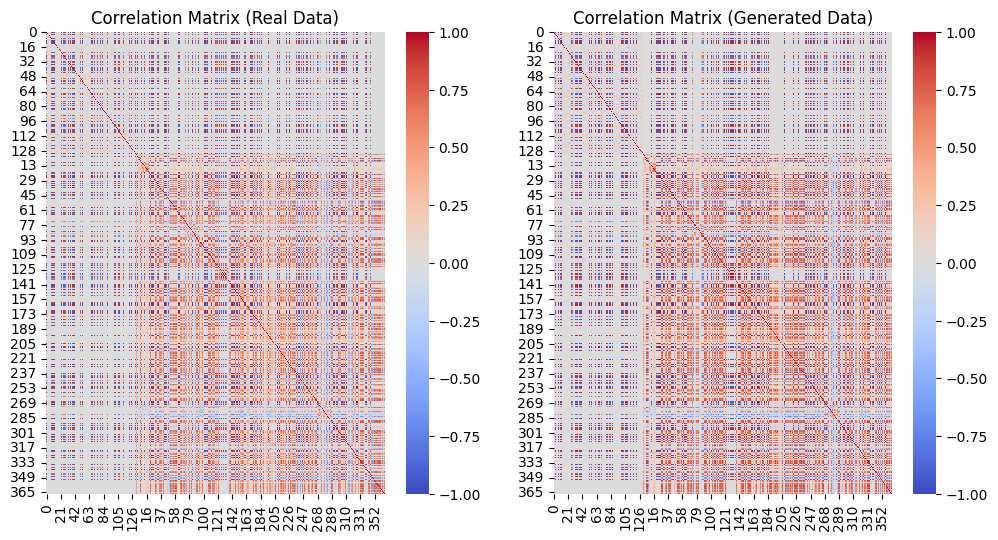

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2983
           1       1.00      1.00      1.00      3017

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



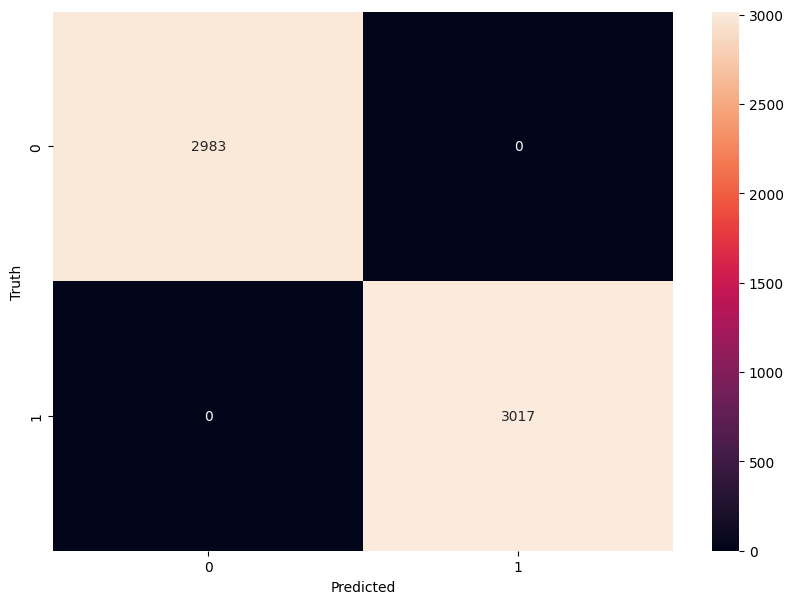

SVC: Solo una clase


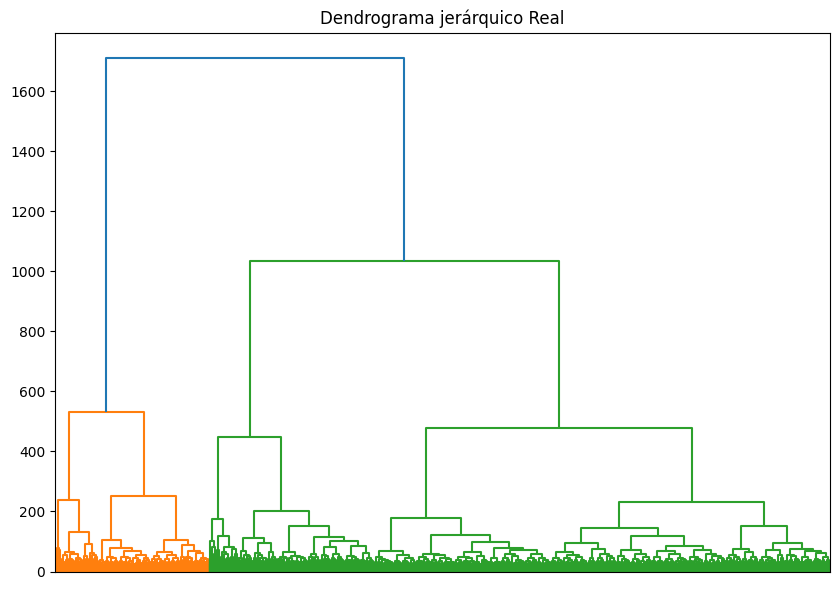

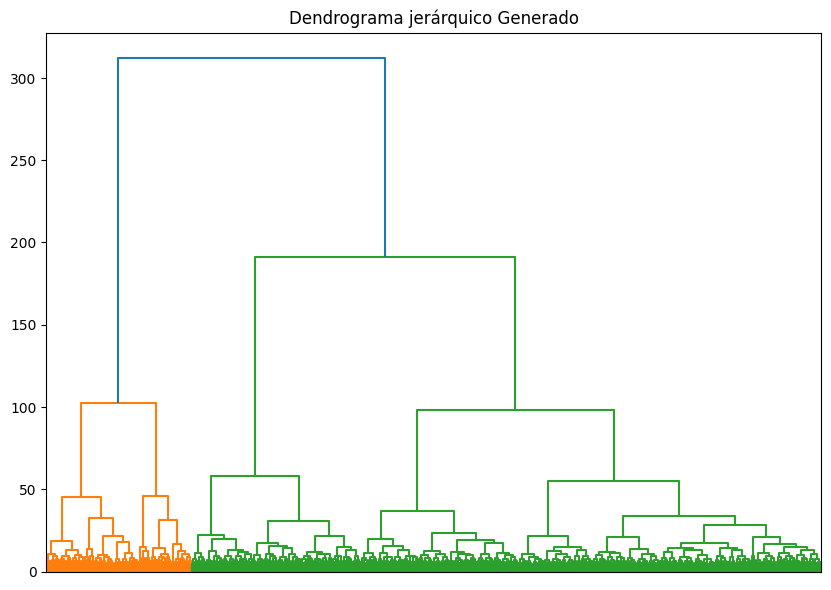

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


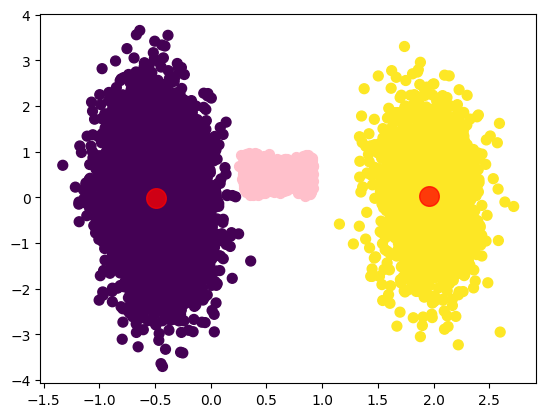

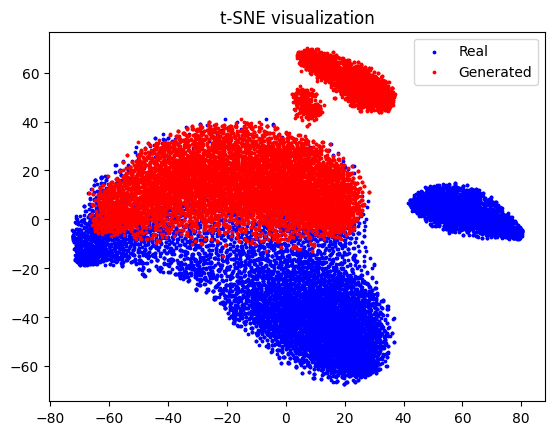

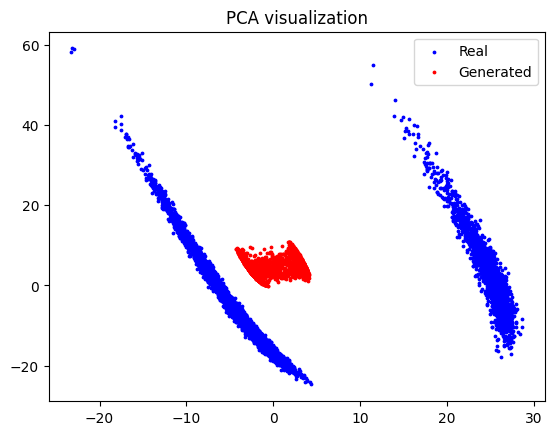

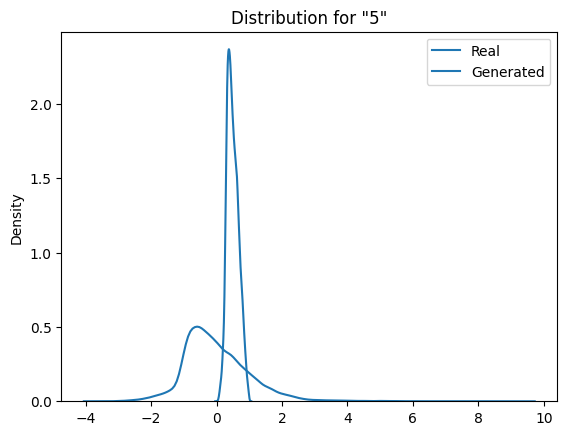

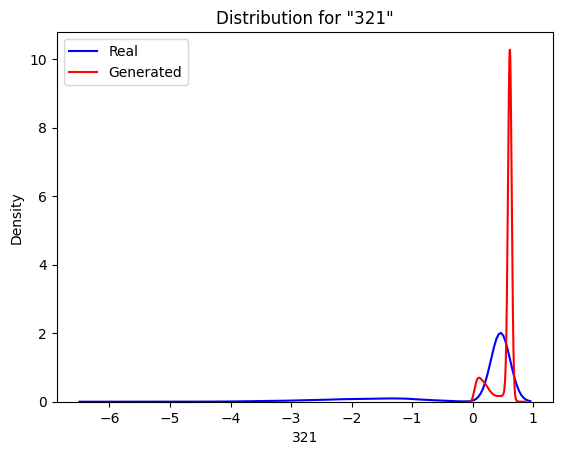

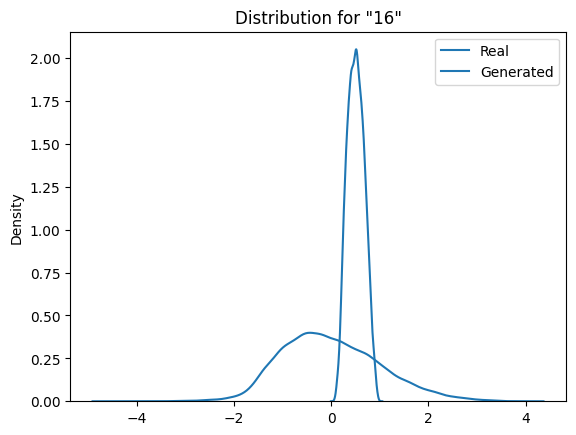

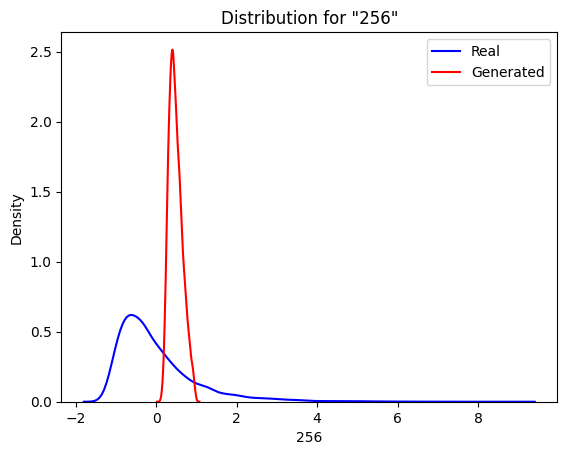

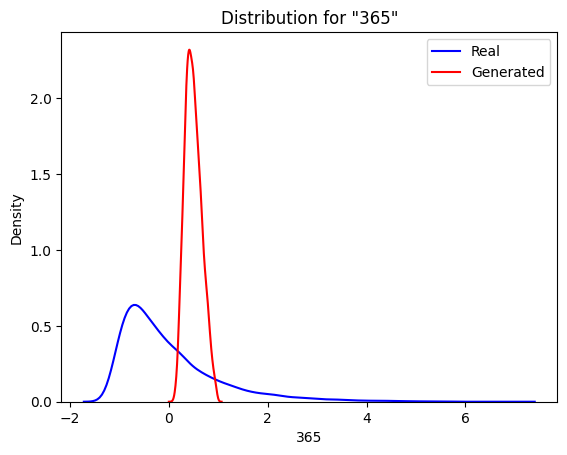

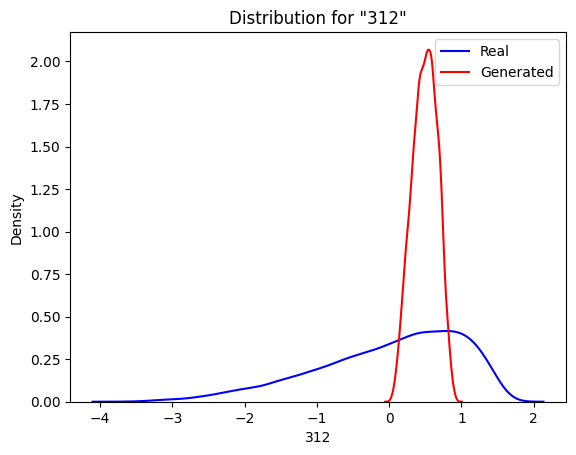

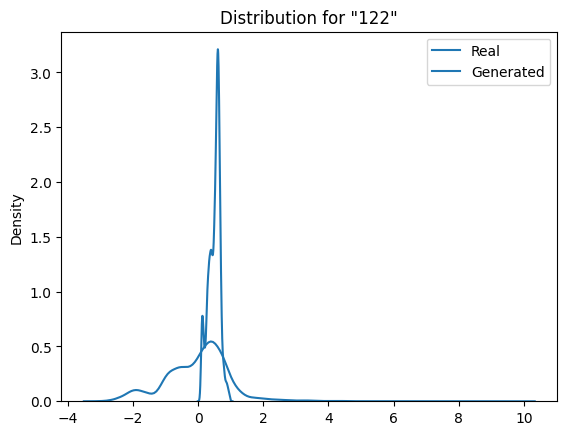

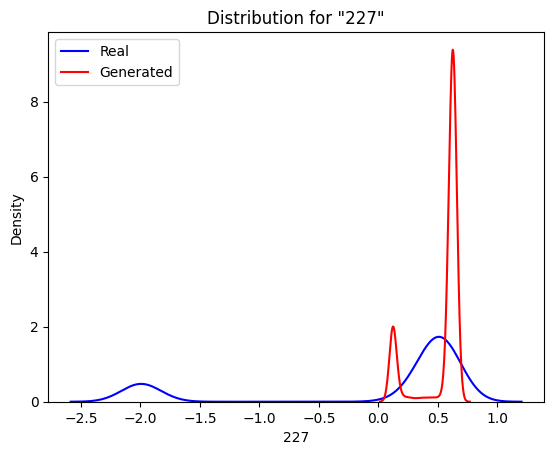

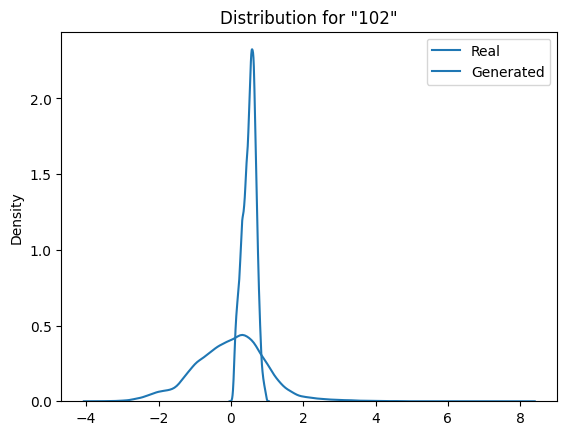

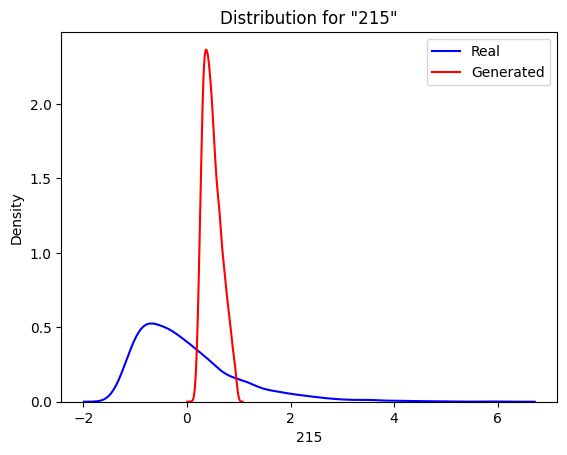

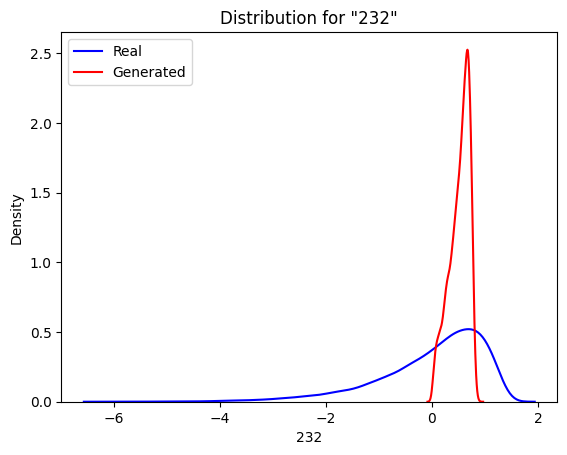

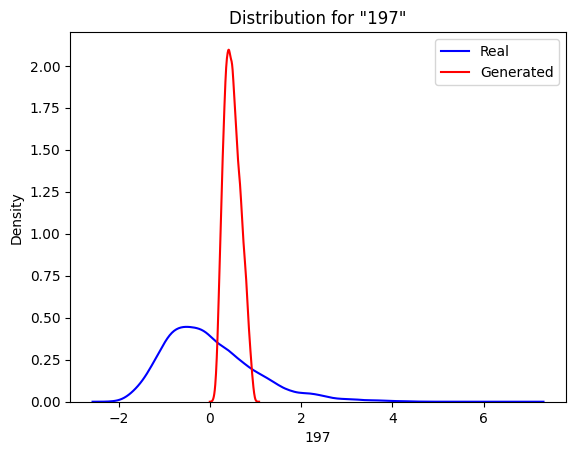

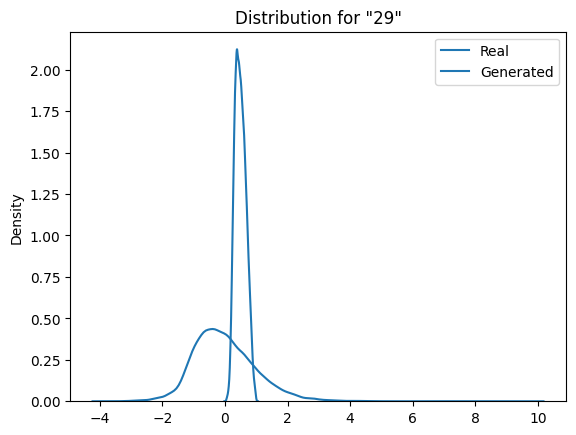

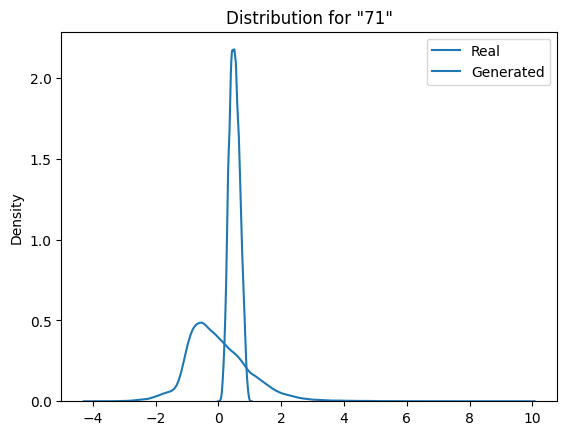

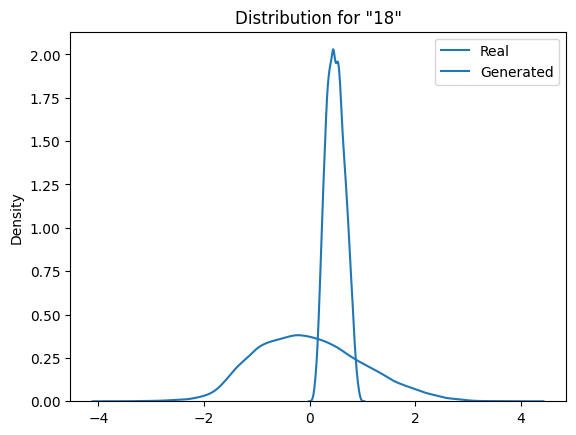

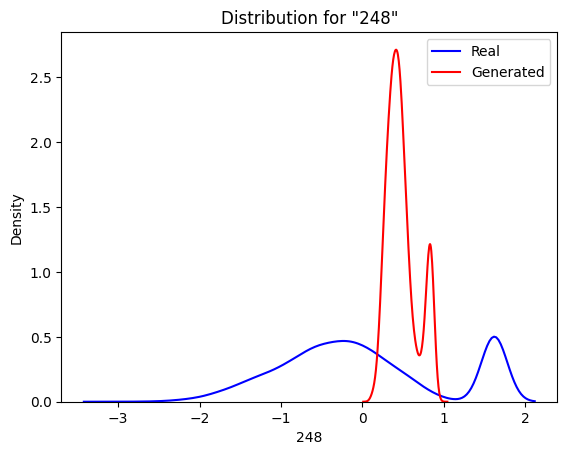

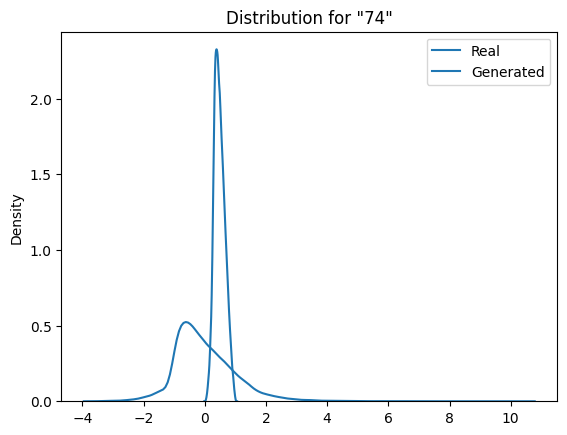

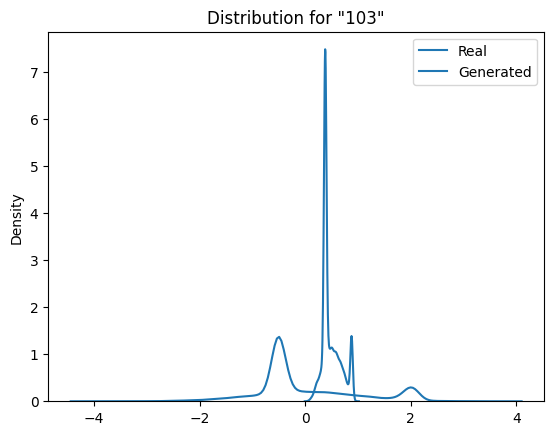

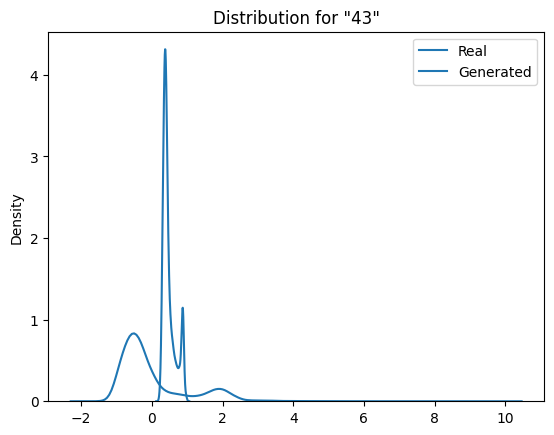

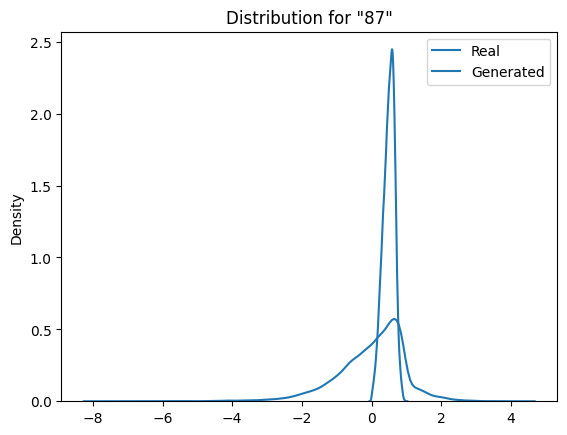

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
sys.setrecursionlimit(20000)
# Cargamos los datos
expr_data = pd.read_csv(fnexpr)
meth_data = pd.read_csv(fnmet)
assig_data = pd.read_csv(fnassig)
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0 (CAMBIAR)
#expr_data.fillna(0, inplace=True)
#meth_data.fillna(0, inplace=True)
#assig_data.fillna(0, inplace=True)

expr_data = scaler.fit_transform(expr_data)
meth_data = scaler.fit_transform(meth_data)
expr_data = pd.DataFrame(expr_data)
meth_data = pd.DataFrame(meth_data)
assig_data = pd.DataFrame(assig_data)

# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)

# Generar datos de expresión sintética
vae = VAE(combined_data.shape[1],ldim).to(device)
vae.load_state_dict(torch.load(fnmodel))
vae.eval()

# Función para reparametrización (para generar muestras del espacio latente)

# Generar datos de expresión sintética

with torch.no_grad():
    z = torch.randn(nsamp, ldim).to(device)
    synthetic_expression = vae.decoder(z).to(device)
    synthetic_expression = torch.sigmoid(synthetic_expression)
    #print(synthetic_expression)
    expressions_list=synthetic_expression.detach().cpu().numpy().squeeze()

X_gan = pd.DataFrame(expressions_list)
#X = X.apply(pd.to_numeric, errors='coerce')
y = X_gan.iloc[:, -1].values.astype(int)  

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])



# Aplanar los datos para cálculos estadísticos
real_data_flattened = X_real.values.flatten()
generated_data_flattened = X_gan.values.flatten()

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_flattened, generated_data_flattened)

# KS Test
ks_statistic, ks_pvalue = ks_2samp(real_data_flattened, generated_data_flattened)

print(f"Wasserstein Distance: {w_distance}")
print(f"KS Statistic: {ks_statistic}, P-Value: {ks_pvalue}")

# Suponiendo que X_real y X_gan son tus dos grupos de datos
distancias_euclidianas = cdist(X_real, X_gan, metric='euclidean')

# Calcular la distancia promedio
distancia_promedio_euclidiana = np.mean(distancias_euclidianas)
print("Distancia Euclidiana Promedio:", distancia_promedio_euclidiana)

# Calcula las matrices de correlación
corr_real = X_real.corr()
corr_gan = X_gan.corr()

# Dibuja las matrices de correlación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(corr_real, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Real Data)')

plt.subplot(1, 2, 2)
sns.heatmap(corr_gan, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Generated Data)')

plt.show()

# Etiquetas: 1 para real, 0 para generado
y_real = [1] * X_real.shape[0]
y_gan = [0] * X_gan.shape[0]

# Combina los datos y las etiquetas
#X_combined = pd.concat([X_real, X_gan], axis=0)
y_combined = y_real + y_gan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Inicializa y entrena el clasificador SVC
svc = SVC()
svc.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = svc.predict(X_test)
# Evalúa el rendimiento del clasificador
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(filename+"SVC1.jpg")
plt.show()


# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    # Predicciones
    y_pred = clf.predict(X_test)
    
    # Métricas de clasificación
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC2.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")



# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()



#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Dibujar el resultado
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()


#KDE
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real',color='blue')
    sns.kdeplot(X_gan[column_name], label='Generated',color='red')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"{filename}kde-{column_name}.jpg")
    plt.show()